In [1]:
import tensorflow as tf
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)


[] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
%%time
import pyarrow.parquet as pq
import pandas as pd
import re
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import pos_tag # 词性
from nltk.tokenize import word_tokenize # 分词
from nltk.corpus import stopwords # 停用词
from nltk.stem import PorterStemmer, WordNetLemmatizer # 词干化，词态统一
from tqdm import tqdm  # 显示处理进度
tqdm.pandas(desc="Processing excerpts")



lemmatizer = WordNetLemmatizer()
#Different sources of stopwords
nltk_stopwords = set(stopwords.words('english')) 
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
wordcloud_stopwords = set(STOPWORDS)
with open('.\\dictionaries\\expandedstopwords.txt', 'r') as file:
    txt_stopwords = [line.strip() for line in file.readlines()]
    
stopwords_df = pd.DataFrame({'Words': txt_stopwords})
additional_stopwords = set(stopwords_df.to_numpy().flatten())

CPU times: total: 281 ms
Wall time: 1.01 s


In [3]:
%%time
# 清洗文本数据
def clean_text(text):
    # 去除特殊字符和标点符号
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # 小写化文本
    text = text.lower()
    return text

# 分词和词形还原
def tokenize_and_lemmatize(text):
    tqdm.pandas(desc="Tokenizing")
    # 分词
    words = nltk.word_tokenize(text)
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# 去停用词
def remove_stopwords(tokens):
    stop_words = sklearn_stopwords.union(additional_stopwords, wordcloud_stopwords, nltk_stopwords)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# 词干化
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]  # 添加进度条
    return stemmed_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
%%time
# 一次性解决四个任务，优化代码，减少循环次数。建议apply
def preprocess_text(text):
    # 基本处理
    cleaned_text = clean_text(text)
    # 分词和词形还原
    lemmatized_tokens = tokenize_and_lemmatize(cleaned_text)
    # 去停用词
    non_stop_words = remove_stopwords(lemmatized_tokens)
    # 词干化
    stemmed_tokens = stem_tokens(non_stop_words)
    return stemmed_tokens

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
# 假设我们有经济危机时间戳的数据列表
crisis_timestamps = [
    "1986:1 Credit disrupt.-minus",
    "1990:1 Minor crisis-reg.",
    "1990:2 Moderate crisis-minus",
    "1991:1 Minor crisis-minus",
    "1991:2 Credit disrupt.-plus",
    "1992:1 Credit disrupt.-reg.",
    "1998:2 Credit disrupt.-plus",
    "2007:1 Credit disrupt.-minus",
    "2007:2 Moderate crisis-minus",
    "2008:1 Moderate crisis-plus",
    "2008:2 Extreme crisis-reg.",
    "2009:1 Major crisis-minus",
    "2009:2 Moderate crisis-minus",
    "2010:1 Minor crisis-plus",
    "2010:2 Credit disrupt.-plus",
    "2011:2 Credit disrupt.-reg.",
    "2012:1 Credit disrupt.-minus",
    "2012:2 Credit disrupt.-minus"
]

# 定义危机的严重程度和修饰符的标量值
crisis_severity = {
    'Minor crisis': 4,
    'Moderate crisis': 7,
    'Major crisis': 10,
    'Extreme crisis': 13,
    'Credit disrupt.': 1  
}

# 对修饰符进行数值调整
modifier_adjustment = {
    'minus': 0.0,
    'plus': 2.0,
    'reg.': 1.0
}

# 创建一个空的DataFrame来存储结果
crisis_data = pd.DataFrame(columns=['Year', 'Severity', 'Binary_Crisis'])

# 处理每个时间戳，填充DataFrame
for timestamp in crisis_timestamps:
    # 解析年份和描述
    year, _, description = timestamp.partition(':')
    year = int(year)  # 转换年份为整数
    # 解析危机类型和修饰符
    for crisis_type in crisis_severity:
        if crisis_type in description:
            severity_value = crisis_severity[crisis_type]
            # 找到修饰符并进行调整
            for modifier in modifier_adjustment:
                if modifier in description:
                    severity_value += modifier_adjustment[modifier]
                    break  # 找到修饰符后无需继续查找
            # 添加到DataFrame
            crisis_data = crisis_data._append({
                'Year': year,
                'Severity': severity_value,
                'Binary_Crisis': 1  # 如果记录中有危机描述则标为1
            }, ignore_index=True)
            break  # 危机类型已找到，无需继续其它类型的检查

# 确保年份是整数类型
crisis_data['Year'] = crisis_data['Year'].astype(int)
crisis_data['Binary_Crisis'] = crisis_data['Binary_Crisis'].astype(int)
# 输出结果
crisis_data

C:\Users\ROG\AppData\Local\Temp\ipykernel_10072\2301511474.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crisis_data = crisis_data._append({


,Year,Severity,Binary_Crisis
0,1986,1.0,1
1,1990,5.0,1
2,1990,7.0,1
3,1991,4.0,1
4,1991,3.0,1
5,1992,2.0,1
6,1998,3.0,1
7,2007,1.0,1
8,2007,7.0,1
9,2008,9.0,1


In [6]:
# 首先，对同一年份的危机严重性分数求和并取平均值
# 对Binary_Crisis采取最大值，因为如果有危机，Binary_Crisis应该是1
aggregated_crisis_data = crisis_data.groupby('Year').agg({'Severity': 'max', 'Binary_Crisis': 'max'}).reset_index()

# 现在，aggregated_crisis_data 将有每个年份的危机严重性分数总和，且Binary_Crisis为1（如果那年发生了危机）
print(aggregated_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       1.0              1
1   1990       7.0              1
2   1991       4.0              1
3   1992       2.0              1
4   1998       3.0              1
5   2007       7.0              1
6   2008      14.0              1
7   2009      10.0              1
8   2010       6.0              1
9   2011       2.0              1
10  2012       1.0              1


In [7]:
# Find the range of years you want to cover
full_year_range = range(aggregated_crisis_data['Year'].min(), aggregated_crisis_data['Year'].max() + 1)

# Create a DataFrame with all years in the range
all_years_df = pd.DataFrame(full_year_range, columns=['Year'])

# Merge with the existing crisis data
# This will keep all entries from all_years_df and match entries from crisis_data where available
complete_crisis_data = all_years_df.merge(aggregated_crisis_data, on='Year', how='left')

# Fill NaN values with 0 for 'Severity' and 'Binary_Crisis'
complete_crisis_data['Severity'].fillna(0, inplace=True)
complete_crisis_data['Binary_Crisis'].fillna(0, inplace=True)

# The resulting DataFrame will have all years filled, with 0 for missing years
print(complete_crisis_data)

    Year  Severity  Binary_Crisis
0   1986       1.0            1.0
1   1987       0.0            0.0
2   1988       0.0            0.0
3   1989       0.0            0.0
4   1990       7.0            1.0
5   1991       4.0            1.0
6   1992       2.0            1.0
7   1993       0.0            0.0
8   1994       0.0            0.0
9   1995       0.0            0.0
10  1996       0.0            0.0
11  1997       0.0            0.0
12  1998       3.0            1.0
13  1999       0.0            0.0
14  2000       0.0            0.0
15  2001       0.0            0.0
16  2002       0.0            0.0
17  2003       0.0            0.0
18  2004       0.0            0.0
19  2005       0.0            0.0
20  2006       0.0            0.0
21  2007       7.0            1.0
22  2008      14.0            1.0
23  2009      10.0            1.0
24  2010       6.0            1.0
25  2011       2.0            1.0
26  2012       1.0            1.0


加载数据集

- 原始数据集

In [8]:
%%time
# 加载数据
data = pd.read_parquet('.\\nyt_data.parquet')
data.head()

CPU times: total: 19.9 s
Wall time: 19.7 s


,year,title,excerpt
0,1920,At last the Federal Reserve Board has issued r...,
1,1920,WILL TEST DOOR SERVICE.,Service Board to Further Examine I.R.T. Safety...
2,1920,Sanction for Chinese Contracts.,
3,1920,"LEADS FRAZIER BY 4,496.",Langer's Margin Falls in North Dakota--Gronna ...
4,1920,"CHICAGO, April 30.--With 300 suspicious charac...",Federal Agents and Police Round-- up Suspiciou...


In [9]:
print(data.describe())

               year
count  1.737091e+07
mean   1.965375e+03
std    2.807526e+01
min    1.920000e+03
25%    1.941000e+03
50%    1.961000e+03
75%    1.990000e+03
max    2.020000e+03


In [10]:
# 过滤出1985年及以后的数据
data_filtered = data[data['year'] >= 1985]

# 显示过滤后的数据描述
data_filtered.describe()

,year
count,5.204829e+06
mean,2.001664e+03
std,9.731762e+00
min,1.985000e+03
25%,1.993000e+03
50%,2.002000e+03
75%,2.009000e+03
max,2.020000e+03


In [127]:
%%time
# 取数据集的10%
#data_sample = data_filtered.sample(frac=0.1, random_state=42)
data_sample = data_filtered
# 查看数据集的样本大小
print("Sample size:", len(data_sample))
data_sample.describe()

Sample size: 5204829
CPU times: total: 125 ms
Wall time: 152 ms


,year
count,5.204829e+06
mean,2.001664e+03
std,9.731762e+00
min,1.985000e+03
25%,1.993000e+03
50%,2.002000e+03
75%,2.009000e+03
max,2.020000e+03


In [ ]:
data_sample['processed_excerpt'] = data_sample['excerpt'].apply(preprocess_text)

In [175]:
display(data_sample['excerpt'])

12166084     
12166085     
12166086     
12166087     
12166088     
           ..
17370908     
17370909     
17370910     
17370911     
17370912     
Name: excerpt, Length: 5204829, dtype: object

In [130]:
print(data_sample['processed_excerpt'].values[1])

[]


In [ ]:
text_excerpt = []
for i in data_sample['processed_excerpt'].values:
    if i != []:
        text_excerpt.append(','.join(i))
    else:
        text_excerpt.append('')
        
text_excerpt

In [134]:
print(len(text_excerpt))

5204829


In [135]:
data_sample['processed_txt'] = text_excerpt

C:\Users\ROG\AppData\Local\Temp\ipykernel_10072\3289302444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample['processed_txt'] = text_excerpt


词典

In [136]:
%%time
# 从txt文件读取词汇
with open('.\\dictionaries\\unionOfDicts.txt', 'r') as file:
    txt_data = [line.strip() for line in file.readlines()]

with open('.\\dictionaries\\ubaltFin.txt', 'r') as file:
    ubaltFin_data = [line.strip() for line in file.readlines()]
    
# 创建包含文本文件中词汇的DataFrame
txt_df = pd.DataFrame({'Word': txt_data})
ubaltFin_df = pd.DataFrame({'Word': ubaltFin_data})  
# 从Excel文件读取词典数据
excel_df = pd.read_excel('.\\dictionaries\\financial_stability.xlsx')

# 合并两个DataFrame
lm_dict = pd.concat([txt_df, excel_df, ubaltFin_df], ignore_index=True)

# 显示合并后的DataFrame
print(lm_dict)

                      Word  Positive  Negative
0           hyperinflation       NaN       NaN
1               fiat money       NaN       NaN
2            law economics       NaN       NaN
3          creditor nation       NaN       NaN
4           mortgage terms       NaN       NaN
...                    ...       ...       ...
17366  balance account zba       NaN       NaN
17367      zerocoupon bond       NaN       NaN
17368               profit       NaN       NaN
17369         substitution       NaN       NaN
17370             sum game       NaN       NaN

[17371 rows x 3 columns]
CPU times: total: 15.6 ms
Wall time: 40 ms


In [137]:
%%time
# 将词典索引小写化
lm_dict['Word'] = lm_dict['Word'].str.lower()

CPU times: total: 0 ns
Wall time: 5 ms


In [138]:
lm_dict.drop_duplicates(subset = ['Word'])
print(lm_dict['Word'])

0             hyperinflation
1                 fiat money
2              law economics
3            creditor nation
4             mortgage terms
                ...         
17366    balance account zba
17367        zerocoupon bond
17368                 profit
17369           substitution
17370               sum game
Name: Word, Length: 17371, dtype: object


In [139]:
# # 金融词频（总词频）统计，你想要的可能是每一年的词频统计，那么请你筛选出年份，然后把下面的data_sample替换为你筛选好的年份即可
from collections import Counter
# # 提取词典中的所有词汇
all_words = lm_dict.index.tolist()
# # 初始化一个词频统计字典
all_words_count = Counter()

### 使用lm_dict进行tf-idf

In [ ]:
tfidf_vector = []
for year, group in data_sample.groupby('year'):
    # 为当前年份创建 TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(vocabulary=list(set(lm_dict['Word'])))
    
    # 将当前年份的文本数据转换为 TF-IDF 向量表示
    tfidf_data = tfidf_vectorizer.fit_transform(pd.Series(' '.join(group['processed_txt'])))

    # 将 TF-IDF 结果转换为 DataFrame
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns=list(set(lm_dict['Word'])))
    tfidf_vector.append(tfidf_df)

# 输出 TF-IDF 统计结果
for i, year_tfidf in enumerate(tfidf_vector):
    print(f"TF-IDF vectors for year {i + 1}:\n{year_tfidf}")

In [141]:
# 假设 tfidf_vector 是一个包含 TF-IDF 向量的列表，每个元素都是一个 DataFrame

# 合并所有年份的 TF-IDF 向量
combined_tfidf = pd.concat(tfidf_vector, ignore_index=True)

# 计算每个词的平均 TF-IDF 分数
mean_tfidf_scores = combined_tfidf.mean(axis=0)

# 找到分数最高的词
top_words = mean_tfidf_scores.nlargest(10)  # 假设想要找到出现频率最高的前 10 个词

print("Top words based on TF-IDF scores:")
print(top_words)


Top words based on TF-IDF scores:
book      0.303739
life      0.289455
tax       0.243281
news      0.226573
market    0.211609
record    0.148336
good      0.135744
law       0.134356
bank      0.126359
rule      0.120119
dtype: float64


In [ ]:
print(combined_tfidf)

In [143]:
#PCA 降维
from sklearn.decomposition import TruncatedSVD

# 初始化 TruncatedSVD 模型并拟合
n_components = 500  # 设置要降到的维度数
svd = TruncatedSVD(n_components=n_components)
reduced_tfidf = svd.fit_transform(combined_tfidf)
print(reduced_tfidf)

[[ 9.44845559e-01 -5.72790187e-02 -1.94433401e-02 ...  9.25404776e-03
   7.36737090e-04 -9.10142848e-04]
 [ 9.43403106e-01 -7.13869455e-02  1.99828856e-02 ... -3.95674234e-03
   8.54970202e-04 -5.57727942e-04]
 [ 7.69650692e-01 -3.98870183e-01  3.68974422e-01 ... -3.16024769e-04
   1.45280175e-03 -1.45627212e-03]
 ...
 [ 6.53868099e-01  4.04580023e-01  7.13390049e-02 ... -1.38571637e-03
   5.92620343e-06 -5.07818592e-04]
 [ 8.09956260e-01  2.22203061e-01  6.78388604e-02 ... -8.97529409e-04
  -3.92959779e-04 -3.18085712e-04]
 [ 7.48222594e-01  1.76228112e-01  4.13572365e-02 ...  1.76640194e-03
  -8.72646372e-04  1.62373211e-03]]


- 二分类预测

In [144]:
# 构建特征集和标签集
features = []
labels = []
for year in range(1985, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features = reduced_tfidf[:27]
        labels.append(1 if year + 1 in complete_crisis_data[complete_crisis_data['Binary_Crisis'] == 1]['Year'].values else 0)

# 分割数据集
# 假设我们使用前23年(0.8)的数据作为训练集，剩下的数据作为测试集
train_features = features[:23]
train_labels = labels[:23]
test_features = features[23:]
test_labels = labels[23:]

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

# 定义要尝试的多个模型
models = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(kernel='rbf'),
    KNeighborsClassifier(n_neighbors=3) 
]

for model in models:
    model.fit(train_features, train_labels )  # 使用相同的训练集训练每个模型
    y_pred = model.predict(train_features)  # 对测试集进行预测
    accuracy = accuracy_score(train_labels, y_pred)  # 计算准确率
    report = classification_report(train_labels, y_pred)  # 生成分类报告

    # 输出模型性能
    print(f"Model: {type(model).__name__}")
    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    print("-------------------------------------------")


D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarn

Model: LogisticRegression
Accuracy: 0.6956521739130435
Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        16
           1       0.00      0.00      0.00         7

    accuracy                           0.70        23
   macro avg       0.35      0.50      0.41        23
weighted avg       0.48      0.70      0.57        23

-------------------------------------------
Model: RandomForestClassifier
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         7

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

-------------------------------------------
Model: SVC
Accuracy: 0.6956521739130435
Classification Report:
              precision    recall  f1-score   supp

- 回归预测severity

In [154]:
# 构建特征集和标签集
features = []
labels = []
for year in range(1985, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features = reduced_tfidf[:27]
        labels = complete_crisis_data['Severity']

# 分割数据集
# 假设我们使用前23年(0.8)的数据作为训练集，剩下的数据作为测试集
train_features = features[:23]
train_labels = labels[:23]
test_features = features[23:]
test_labels = labels[23:]

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
# 定义要尝试的多个模型
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    SVR(kernel='rbf',C=300, epsilon=0.1),
    Ridge(alpha=0.5),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)  
]

for model in models:
    model.fit(train_features, train_labels )  # 使用相同的训练集训练每个模型
    y_pred = model.predict(train_features)  # 对测试集进行预测
    mse = mean_squared_error(train_labels, y_pred)
    r2 = r2_score(train_labels, y_pred)
    # 输出模型性能
    print(f"Model: {type(model).__name__}")
    print(f"MSE: {mse}")
    print(f"R2 Scoret:\n{r2}")
    print("-------------------------------------------")


Model: RandomForestRegressor
MSE: 1.6720739130434783
R2 Scoret:
0.8527751165113182
-------------------------------------------
Model: SVR
MSE: 0.013155039978715229
R2 Scoret:
0.9988417083640578
-------------------------------------------
Model: Ridge
MSE: 5.209165603245959
R2 Scoret:
0.5413367836023447
-------------------------------------------
Model: GradientBoostingRegressor
MSE: 0.04646667919830481
R2 Scoret:
0.9959086429267804
-------------------------------------------


In [157]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# 假设 svr 是你训练好的支持向量机回归模型
svr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=42)  
svr.fit(train_features, train_labels)

# 对训练集和测试集进行预测
predictions = svr.predict(features)
train_predictions = svr.predict(train_features)
test_predictions = svr.predict(test_features)


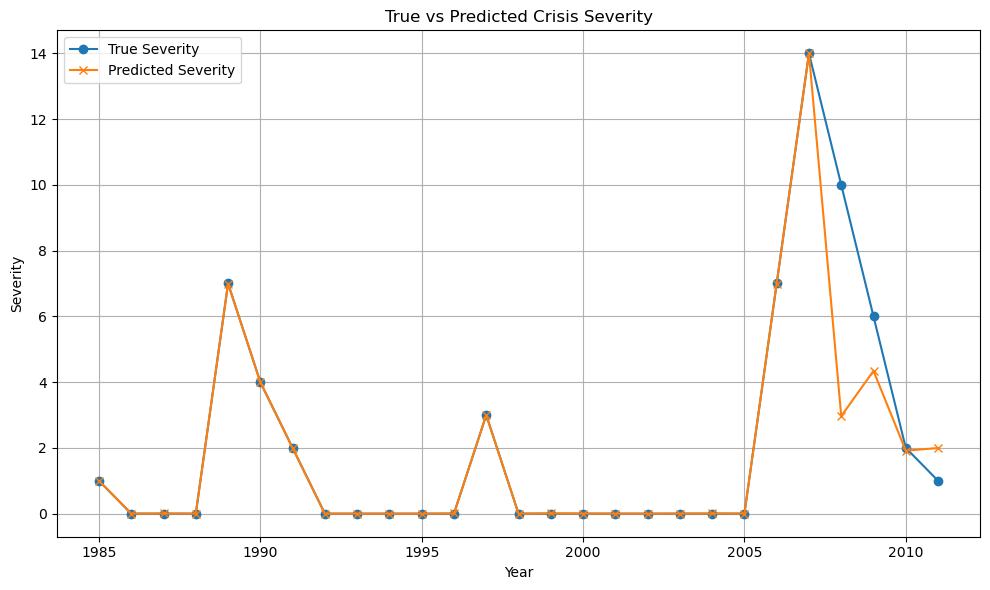

CPU times: total: 141 ms
Wall time: 182 ms


In [158]:
%%time
import matplotlib.pyplot as plt

# 假设 linear_labels 和 predictions 分别是真实标签和预测结果

# 确保 linear_labels 和 predictions 的长度相同
# 使用 Matplotlib 绘制折线图
years = range(1985, 2012)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, labels, label='True Severity', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predictions, label='Predicted Severity', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Severity')
plt.title('True vs Predicted Crisis Severity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- rolling test

In [151]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 假设你有名为 data 和 labels 的时间序列数据

# 构建特征集和标签集
features = []
labels = []
for year in range(1985, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features = reduced_tfidf[:27]
        labels = complete_crisis_data['Severity']
        
# 找到 1990 年对应的索引
start_year = 1990
start_index = start_year - 1985 # 如果索引从0开始计数

# 创建 SVR 模型
svr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)  

# 开始 rolling test
predict_result = []
n_splits = len(labels) - start_index - 1 # 从指定年份开始的数据长度
for i in range(n_splits):
    train_data = features[:start_index + i]  # 使用起始年份到当前年份的数据作为训练集
    train_labels = labels[:start_index + i]

    # 训练 SVR 模型
    svr.fit(train_data, train_labels)

    # 对测试集进行预测
    test_data = features[start_index + i :start_index + i + 1]  # 测试下一年的数据
    predictions = svr.predict(test_data)

    # 计算评估指标
    test_labels = labels[start_index + i :start_index + i + 1]
    mse = mean_squared_error(test_labels, predictions)
    print(f"Year {start_year + i } Mean Squared Error: {mse}Prediction result: {predictions}")
    predict_result.append([predictions[0]])

    # 可以在这里进行其他操作，比如保存模型、绘制图表等
    

Year 1990 Mean Squared Error: 10.88810176876641Prediction result: [0.70028762]
Year 1991 Mean Squared Error: 1.8709667835401973Prediction result: [3.36783288]
Year 1992 Mean Squared Error: 4.106679680103723Prediction result: [2.02649443]
Year 1993 Mean Squared Error: 2.461821945700107e-06Prediction result: [0.00156902]
Year 1994 Mean Squared Error: 0.5674284480888632Prediction result: [0.75327847]
Year 1995 Mean Squared Error: 1.7292005406002344Prediction result: [1.3149907]
Year 1996 Mean Squared Error: 7.027825160601244e-07Prediction result: [0.00083832]
Year 1997 Mean Squared Error: 6.9278743264219615Prediction result: [0.36791445]
Year 1998 Mean Squared Error: 0.053501221004225635Prediction result: [0.23130331]
Year 1999 Mean Squared Error: 2.638121090282828Prediction result: [1.62422938]
Year 2000 Mean Squared Error: 2.4622576099034905Prediction result: [1.56915825]
Year 2001 Mean Squared Error: 0.39608470057805356Prediction result: [0.6293526]
Year 2002 Mean Squared Error: 0.0527

In [171]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 假设你有名为 data 和 labels 的时间序列数据

# 构建特征集和标签集
features = []
labels = []
for year in range(1985, 2012):  # 2012是最后一个有危机标签的年份
    if year + 1 in complete_crisis_data['Year'].values:  # 确保我们有下一年的危机信息
        features = reduced_tfidf[:27]
        labels = complete_crisis_data['Severity']
        
# 找到 1990 年对应的索引
start_year = 1990
start_index = start_year - 1985 # 如果索引从0开始计数

# 创建 SVR 模型
svr = SVR(kernel='rbf',C=300, epsilon=0.3)

# 开始 rolling test
predict_result = []
n_splits = len(labels) - start_index - 1 # 从指定年份开始的数据长度
for i in range(n_splits):
    train_data = features[:start_index + i]  # 使用起始年份到当前年份的数据作为训练集
    train_labels = labels[:start_index + i]

    # 训练 SVR 模型
    svr.fit(train_data, train_labels)

    # 对测试集进行预测
    test_data = features[start_index + i :start_index + i + 1]  # 测试下一年的数据
    predictions = svr.predict(test_data)

    # 计算评估指标
    test_labels = labels[start_index + i :start_index + i + 1]
    mse = mean_squared_error(test_labels, predictions)
    print(f"Year {start_year + i } Mean Squared Error: {mse}Prediction result: {predictions}")
    predict_result.append([predictions[0]])

    # 可以在这里进行其他操作，比如保存模型、绘制图表等

Year 1990 Mean Squared Error: 0.005476651431774761Prediction result: [3.9259956]
Year 1991 Mean Squared Error: 12.554115151166263Prediction result: [5.54317868]
Year 1992 Mean Squared Error: 6.227349783456528Prediction result: [2.49546584]
Year 1993 Mean Squared Error: 2.425130986519947Prediction result: [1.55728321]
Year 1994 Mean Squared Error: 3.2821025857927024Prediction result: [1.81165741]
Year 1995 Mean Squared Error: 1.8981618579186148Prediction result: [1.37773795]
Year 1996 Mean Squared Error: 3.0136681611944827Prediction result: [1.73599198]
Year 1997 Mean Squared Error: 5.616470757548531Prediction result: [0.63009056]
Year 1998 Mean Squared Error: 0.539152400010609Prediction result: [0.73426998]
Year 1999 Mean Squared Error: 1.3079824589249893Prediction result: [1.14367061]
Year 2000 Mean Squared Error: 0.02814460458040351Prediction result: [0.16776354]
Year 2001 Mean Squared Error: 0.7802811302107081Prediction result: [0.88333523]
Year 2002 Mean Squared Error: 2.0682453544

In [172]:
len(labels[6:])


21

In [173]:
len(predict_result)

21

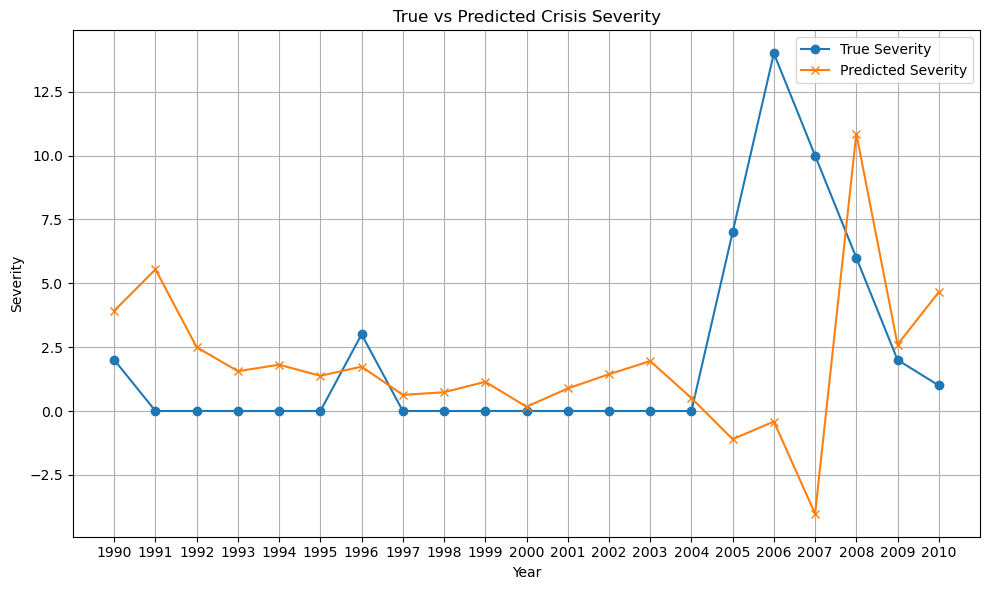

CPU times: total: 203 ms
Wall time: 224 ms


In [174]:
%%time
import matplotlib.pyplot as plt

# 假设 linear_labels 和 predictions 分别是真实标签和预测结果

# 确保 linear_labels 和 predictions 的长度相同
# 使用 Matplotlib 绘制折线图
years = range(1990, 2011)  # 确保年份范围正确
plt.figure(figsize=(10, 6))

# 绘制真实严重性
plt.plot(years, labels[6:], label='True Severity', marker='o', linestyle='-')

# 绘制预测严重性
plt.plot(years, predict_result, label='Predicted Severity', marker='x', linestyle='-')

plt.xlabel('Year')
plt.ylabel('Severity')
plt.title('True vs Predicted Crisis Severity')
plt.legend()
plt.grid(True)
plt.xticks(years, [str(year) for year in years])
plt.tight_layout()
plt.show()

### 不使用lm_dict，直接进行tf-idf(待修改）

In [33]:
#不用字典的版本
tfidf_vector = []
for year, group in data_sample.groupby('year'):
    # 为当前年份创建 TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # 将当前年份的文本数据转换为 TF-IDF 向量表示
    tfidf_data = tfidf_vectorizer.fit_transform(pd.Series(' '.join(group['processed_txt'])))
    
    words_set = tfidf_vectorizer.get_feature_names_out()
    print(words_set)

    # 将 TF-IDF 结果转换为 DataFrame
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns = words_set)
    tfidf_vector.append(tfidf_df)


['00' '007' '010' ... 'zum' 'zurich' 'zurn']
['000' '006' '007' ... 'zurich' 'zwin' 'zywicki']
['010882' '025' '02885' ... 'zukerman' 'zulu' 'zycad']
['007' '010' '016' ... 'zwilich' 'zwiren' 'zyman']
['007' '02' '025' ... 'zvuki' 'zydeco' 'zzzzzz']
['0002' '0003' '001' ... 'zwiebel' 'zwinger' 'zydeco']
['00' '000' '00184' ... 'zypora' 'zytturm' 'zz']
['0004' '007' '01' ... 'zweben' 'zweig' 'zypora']
['00' '0000000' '005' ... 'zwirn' 'zydeco' 'zypora']
['00' '00192' '003' ... 'zwelithini' 'zydeco' 'zz']
['000' '007' '01' ... 'zydeco' 'zygmunt' 'zyuganov']
['00' '000' '0042' ... 'zygouri' 'zyuganov' 'zzzzz']
['00' '000' '007' ... 'zydeco' 'zygmunt' 'zylberberg']
['004' '007' '008' ... 'zyman' 'zyshal' 'zyuganov']
['00' '00004' '00017' ... 'zygot' 'zyrtec' 'zyuganov']
['00' '000' '00007' ... 'zyuganov' 'zyuzin' 'zywiec']
['00' '000066' '00019' ... 'zydeco' 'zylpha' 'zyrtec']
['00002' '000066' '0001' ... 'zyuganov' 'zywicki' 'zz']
['0025' '003' '004' ... 'zymark' 'zyprexa' 'zyrtec']
['00'

In [34]:
# 输出 TF-IDF 统计结果
for i, year_tfidf in enumerate(tfidf_vector):
    print(f"TF-IDF vectors for year {i + 1}:\n{year_tfidf}")

TF-IDF vectors for year 1:
         00      007       010   010022       012     01746       018  \
0  0.000659  0.00033  0.000165  0.00033  0.000165  0.000165  0.000165   

         02      023       04  ...      zorn     zubin  zucchini  zuccolillo  \
0  0.000165  0.00033  0.00033  ...  0.000824  0.000824  0.000659    0.000165   

   zuckerman  zugzwang    zullo      zum    zurich      zurn  
0   0.000824  0.000659  0.00033  0.00033  0.000824  0.000165  

[1 rows x 24842 columns]
TF-IDF vectors for year 2:
        000       006       007     02108       025        05     06438  \
0  0.000598  0.000149  0.000299  0.000299  0.000299  0.000299  0.000448   

      06881        07     08514  ...  zucchini    zucker  zuckerman  zukerman  \
0  0.000299  0.000149  0.000299  ...  0.000598  0.000149   0.000299  0.000299   

       zulu      zuni       zur    zurich      zwin   zywicki  
0  0.000299  0.000149  0.000299  0.001046  0.000299  0.000149  

[1 rows x 26170 columns]
TF-IDF vectors for

TF-IDF vectors for year 36:
         10     10000     100th       104       106        11        12  \
0  0.016409  0.012306  0.008204  0.008204  0.008204  0.004102  0.004102   

         13      1325        14  ...   yeshiva      york    yorker  \
0  0.016409  0.004102  0.008204  ...  0.004102  0.143575  0.004102   

   youngadult     youth    youtub       yun      zane  zimbabwean      zoom  
0    0.004102  0.016409  0.008204  0.012306  0.004102    0.004102  0.008204  

[1 rows x 2141 columns]
